#  Summary of what this capstone will, and may accomplish

* Scrape data from indeed, and return job postings
* properly format location, title, requirements (location done, 
* analyze what words and requirements occur the most
* Determine the quality of each job posting (how generic does it sound, and how common are the phrases that they are using) - this is important, but needs a bit of refinement
* Compare correlation between words used and position

Not required, but would be nice to implement
* add a map to visualize how many postings there are in each city 

Associated web scraper script can be found at 
https://github.com/mhuh22/Thinkful/blob/master/Bootcamp/Unit%207/Indeed%20Job%20Scraper.ipynb

# Packages

In [1]:
# Basic imports
import os
import time
import timeit
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning packages
from sklearn import ensemble
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import normalize

# Natural Language processing
import nltk
import re
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_rcv1
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering packages
import sklearn.cluster as cluster
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from scipy.spatial.distance import cdist

# Plotly packages
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
import cufflinks as cf
import ipywidgets as widgets
from scipy import special
py.offline.init_notebook_mode(connected=True)

In [2]:
# Import the dataframe
job_data = pd.read_csv('data/job_board.csv', index_col=False)
job_data.drop(['Unnamed: 0'], 1, inplace=True)

In [3]:
# Let's check up on the size of our dataframe
job_data.shape

(671, 7)

In [4]:
# Preview the data
job_data.head(10)

,Title,Location,Company,Salary,Synopsis,Query,Metro
0,Data Analyst,"Duluth, MN",Members Cooperative Credit Union,None,The Data Analyst i...,data+analyst,united states
1,Data Analyst,"Elgin, IL",voestalpine High Performance Metals Co...,None,Proven work experi...,data+analyst,united states
2,Data Analyst,"Jersey City, NJ 07311 (Downtown area)",Tradeweb Markets LLC,None,Tradeweb has an op...,data+analyst,united states
3,Web Data Analyst,"Pleasant Prairie, WI 53158",Uline,None,Web Data Analyst. ...,data+analyst,united states
4,SAS Programmer (Data Analyst),"Washington, DC","Oasis Systems, Inc.",None,Perform data proce...,data+analyst,united states
5,CLINICAL SYSTEM DATA ANALYST (STATISTICAL PROG...,"Philadelphia, PA 19102 (City Center West area)",Temple Health,None,Provides clinical ...,data+analyst,united states
6,Junior Data Analyst,"Valhalla, NY",Rectangle Health,None,Data visualization skills (ex. As the Junior D...,data+analyst,united states
7,Business / Data Analyst,"New York, NY 10038 (Financial District area)",Bank of America,None,"Proficient with Data modeling, SQL...",data+analyst,united states
8,Data Analyst,"New York, NY 10005 (Financial District area)",Murmuration,None,The Data Analyst will:. The Data A...,data+analyst,united states
9,Jr. Data Analyst (Data Assurance) ~ Entry Level,"Jersey City, NJ",Genuent,\r\n $20 - $25 an hour,"Data Analyst (Data Assurance) ~ Jersey City, N...",data+analyst,united states


In [5]:
# Doing some data cleaning
for i, row in job_data.iterrows():
    
    # Clean up location column to format 'city, state'
    (job_data['Location'][i]) = ' '.join((job_data['Location'][i]).split(' ', 2)[:2]) 
    
    # Clean up summary column (Better, but doesn't completely remove all whitespace)
    (job_data['Synopsis'][i]) = (job_data['Synopsis'][i]).strip()

In [6]:
# Print number of unique categories for all non-numerical columns
job_data.select_dtypes(include=['object']).nunique()

Title       189
Location    155
Company     338
Salary       76
Synopsis    635
Query         3
Metro         1
dtype: int64

In [7]:
# # View all job titles (Not that useful since there are a LOT)
# plt.rcParams['figure.figsize'] = [20,5]
# plt.xticks(rotation=70)
# plt.title('Title Frequency')

# sns.barplot(job_data['Title'].unique(), job_data['Title'].value_counts(), data=job_data)

# Data Visualization

In [8]:
# Print out unique job titles and frequencies
job_data['Title'].value_counts()

Data Scientist                                                     119
Data Analyst                                                       104
Data Engineer                                                       75
Junior Data Scientist                                               13
Big Data Engineer                                                    7
Junior Data Analyst                                                  7
Data Analyst Intern                                                  5
Data Analyst (Entry Level)                                           5
Entry Level Business Analyst                                         5
Product Data Analyst                                                 5
Data Entry Analyst                                                   5
Junior Data Engineer                                                 4
Data Scientist / Predictive Modeler                                  4
Associate Data Scientist                                             4
Data C

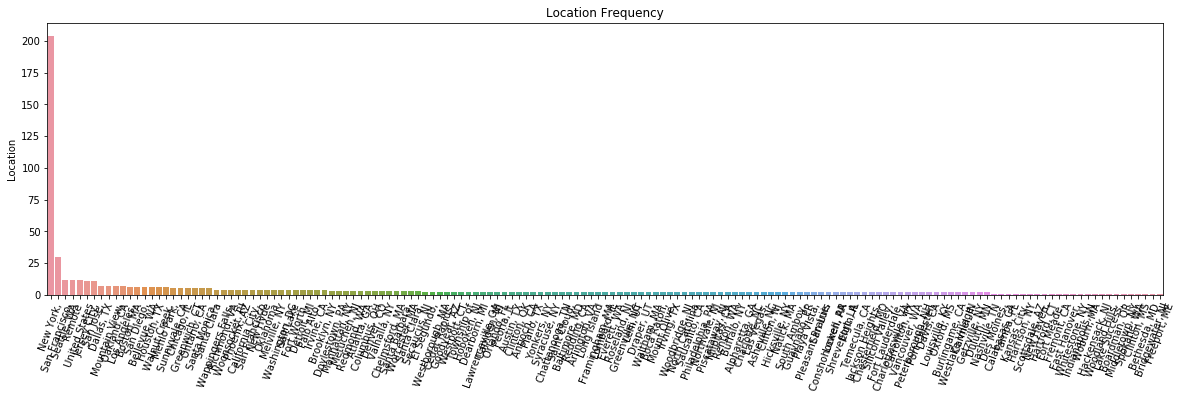

In [9]:
# Plot occurences of each location
# (Not used for anything yet, idk if I'll keep it)
plt.rcParams['figure.figsize'] = [20,5]
plt.xticks(rotation=70)
plt.title('Location Frequency')
x = job_data['Location'].value_counts().index.tolist()
y = job_data['Location'].value_counts()

sns.barplot(x, y, data=job_data)

In [10]:
# Create series with location count
# (Not used for anything yet, idk if I'll keep it)
location_data = job_data['Location'].value_counts()
location_data

New York,            204
San Francisco,        30
Seattle, WA           12
Remote                12
United States         12
Jersey City,          11
San Jose,             11
Dallas, TX             7
Mountain View,         7
Oakland, CA            7
Los Angeles,           7
Boston, MA             6
San Diego,             6
Bellevue, WA           6
Houston, TX            6
Walnut Creek,          6
Menlo Park,            6
Sunnyvale, CA          5
Chicago, IL            5
Greenwich, CT          5
Ontario, CA            5
Santa Monica,          5
Santa Clara            5
Wappingers Falls,      4
Richmond, VA           4
Woonsocket, RI         4
Phoenix, AZ            4
California City,       4
San Francisco          4
New Hyde               4
                    ... 
Burlingame, CA         2
Westlake Village,      2
Carmel, IN             2
Getzville, NY          2
Duluth, MN             2
Nashville, TN          2
Des Moines,            1
Calabasas, CA          1
Tampa, FL              1


In [11]:
# Attempt at creating a bubble map using geopandas / plotly
# Step 1: get geopandas to import
# Step 2: create geodataframe with city, lat, long
# Step 3: Plotly

# import geopandas
# import geolocator

# location = geolocator.geocode('New York')
# print(location.latitude)

# layout = dict(
#         title = '2014 US city populations<br>(Click legend to toggle traces)',
#         showlegend = True,
#         geo = dict(
#             scope='usa',
#             projection=dict( type='albers usa' ),
#             showland = True,
#             landcolor = 'rgb(217, 217, 217)',
#             subunitwidth=1,
#             countrywidth=1,
#             subunitcolor="rgb(255, 255, 255)",
#             countrycolor="rgb(255, 255, 255)"
#         ),
#     )

# fig = dict(data=cities, layout=layout)
# py.iplot(fig, validate=False, filename='d3-bubble-map-populations')

# lat = pd.Series()
# long = pd.Series()

# for i, row in location_data.iteritems():
#     print(i)
#     lat.append((geolocator.geocode(i)))
#     long.append((geolocator.geocode(i)))

In [12]:
# Cleans up salary data

# Create salary dataframe for postings with salary information
salary_data = job_data.replace(to_replace='None', value=np.nan).dropna()

# Cleaning up salary data
salary_data = salary_data[(~salary_data.Salary.str.contains('an hour')) & (~salary_data.Salary.str.contains('a month'))
                   & (~salary_data.Salary.str.contains('a week')) & (~salary_data.Salary.str.contains('a day'))]
salary_data.Salary = salary_data.Salary.str.replace('a year', '').str.replace(',', '').str.replace('$', '')
salary_data.Salary = salary_data.Salary.str.replace('\(Indeed est.\)', '')

# Reduce ranges to single values
new_salaries = []
for i in salary_data.Salary:
    a = i.split('-')
    if len(a) == 2:
        new_salaries.append(np.mean([float(b) for b in a]))
    else:
        new_salaries.append(float(a[0]))        
salary_data.Salary = new_salaries

In [13]:
# Creates boxplots of the queries

data_analyst = go.Box(
    y=salary_data['Salary'].loc[salary_data['Query']=='data+analyst'],
    name = 'Data Analyst'
)
data_scientist = go.Box(
    y=salary_data['Salary'].loc[salary_data['Query']=='data+scientist'],
    name = 'Data Scientist'
)
data_engineer = go.Box(
    y=salary_data['Salary'].loc[salary_data['Query']=='data+engineer'],
    name = 'Data Engineer'
)
layout = go.Layout(
    title = 'Salary Comparison by Query'
)
data = [data_analyst,data_scientist,data_engineer]
        
fig = go.Figure(data=data,layout=layout)
py.offline.iplot(fig)

<div class="alert alert-block alert-warning">
1. Each salary was computed by converting non-annual salary rates to annual, and taking the average of all ranges. The actual minimum and maximum values are most likely lower and higher respectively.

2. Very few employers (<20%) on Indeed include the salary in the listing (meaning that the numbers shown above are likely higher than the actual numbers.
</div>

# Text Cleaning

In [14]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [15]:
# Remove annoying punctuation from the articles
pd.options.display.max_colwidth = 200
job_data['Synopsis'] = job_data.Synopsis.map(lambda x: text_cleaner(str(x)))
job_data['Synopsis'].head()

0         The Data Analyst is responsible for the collection, analysis and reporting of client/customer data using complex analysis of datasets in areas of research,...
1                                               Proven work experience (preferably 2-3 years) as a data analyst or business data analyst. Job Posting – Data Analyst....
2            Tradeweb has an opening for a Data Analyst within their Market Data group. Candidates should have strong technical skills related to data analysis, data...
3      Web Data Analyst. Uline seeks a Web Data Analyst at its Corporate Headquarters in Pleasant Prairie, WI. Analyze data and provide weekly and monthly reports to...
4    Perform data processing to manipulate the data to prepare for reporting including linking the data to other data sources, formatting the data, supplementing the...
Name: Synopsis, dtype: object

# Natural Language Processing

In [16]:
lemmatizer = WordNetLemmatizer()

# Reduce all text to their lemmas
for summary in job_data['Synopsis']:
    summary = lemmatizer.lemmatize(summary)

In [17]:
# Predict job title using text data
X = job_data['Synopsis']
y = job_data['Query']

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Tf-idf Matrix

In [18]:
# Creating tf-idf matrix
vectorizer = TfidfVectorizer(stop_words='english')
synopsis_tfidf = vectorizer.fit_transform(job_data['Synopsis'])

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=job_data['Query'].nunique()

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 50

In [19]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Parameters for LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Time and run LSA model
start_time = timeit.default_timer()
synopsis_lsa = lsa.fit_transform(synopsis_tfidf)
elapsed_lsa = timeit.default_timer() - start_time

# Extract most common words for LSA
components_lsa = word_topic(synopsis_tfidf, synopsis_lsa, terms)
topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                

In [20]:
from sklearn.decomposition import NMF

# Parameters for NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

# Time and run NNMF model
start_time = timeit.default_timer()
synopsis_nmf = nmf.fit_transform(synopsis_tfidf)
elapsed_nnmf = timeit.default_timer() - start_time

# Extract most common words for NNMF
components_nmf = word_topic(synopsis_tfidf, synopsis_nmf, terms)
topwords['NNMF']=top_words(components_nmf, n_top_words)

In [21]:
# View top words identified by LSA and NNMF
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                LSA              NNMF
0         data 63.2         data 6.32
0     analyst 15.73      analyst 1.81
0        team 13.01      engineer 1.7
0    business 12.63   experience 1.52
0    analysis 12.46     analysis 1.15
0    engineer 12.41  responsible 1.09
0  experience 12.27      sources 0.91
0        work 11.59      looking 0.83
0   analytics 11.14        years 0.82
0   scientist 10.03         team 0.78
0  responsible 8.95          new 0.78
0      looking 7.84    scientist 0.78
0          new 7.64     business 0.73
0      science 7.43   management 0.71
0        using 7.28    warehouse 0.71
0         sets 7.11          sets 0.7
0      support 6.95         work 0.69
0   management 6.86      support 0.67
0      product 6.83         using 0.6
0    engineers 6.65          big 0.55
0       sources 6.6       design 0.55
0     insights 6.57    reporting 0.52
0      working 6.56  development 0.52
0        tools 6.45          join 0.5
0     learning 6.43       seeking 0.5
0  

In [22]:
# Create keyword set with top words identified by LSA
keywords = set(topwords['LSA'].str.split(' ', 0).str[0])

# New dataframe with just the text and query
sentences = job_data[['Synopsis', 'Query']]

In [23]:
# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences['Synopsis']
    df['text_source'] = sentences['Query']
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Populate the row with word counts.
        for word in common_words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [24]:
word_counts = bow_features(sentences, keywords)
word_counts.head()

Processing row 0
Processing row 500


,tools,experience,role,engineer,computer,analysis,work,big,language,apply,...,analyst,knowledge,create,insights,management,including,predictive,scala,text_sentence,text_source
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,"The Data Analyst is responsible for the collection, analysis and reporting of client/customer data using complex analysis of datasets in areas of research,...",data+analyst
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,Proven work experience (preferably 2-3 years) as a data analyst or business data analyst. Job Posting – Data Analyst....,data+analyst
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,"Tradeweb has an opening for a Data Analyst within their Market Data group. Candidates should have strong technical skills related to data analysis, data...",data+analyst
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,"Web Data Analyst. Uline seeks a Web Data Analyst at its Corporate Headquarters in Pleasant Prairie, WI. Analyze data and provide weekly and monthly reports to...",data+analyst
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,"Perform data processing to manipulate the data to prepare for reporting including linking the data to other data sources, formatting the data, supplementing the...",data+analyst


In [25]:
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [26]:
X = job_data['Synopsis']

# Set up parameters for the vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
# tokenize and build vocab
vectorizer.fit(X)

# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)

# encode document
vector = vectorizer.transform([text[0]])

# summarize encoded vector
print(vector.shape)
print(vector.toarray())

{'analyst': 48, 'responsible': 829, 'collection': 164, 'analysis': 47, 'reporting': 815, 'client': 150, 'customer': 221, 'using': 1022, 'complex': 177, 'datasets': 228, 'areas': 72, 'research': 823, 'proven': 765, 'work': 1056, 'experience': 353, 'preferably': 728, 'years': 1065, 'business': 114, 'job': 525, 'tradeweb': 993, 'opening': 659, 'market': 590, 'group': 427, 'candidates': 121, 'strong': 943, 'technical': 977, 'skills': 898, 'related': 809, 'web': 1051, 'seeks': 877, 'corporate': 200, 'analyze': 53, 'provide': 766, 'weekly': 1053, 'monthly': 628, 'reports': 816, 'perform': 695, 'processing': 745, 'manipulate': 584, 'prepare': 730, 'including': 477, 'linking': 559, 'sources': 909, 'formatting': 402, 'supplementing': 955, 'provides': 769, 'clinical': 152, 'request': 818, 'general': 412, 'quantitative': 782, 'management': 580, 'visualization': 1040, 'junior': 529, 'closely': 154, 'operations': 662, 'sales': 853, 'executive': 348, 'teams': 975, 'proficient': 754, 'modeling': 623,


[6.12396398 6.41164605 5.90082043 ... 5.56434819 5.56434819 3.95491028]


NameError: name 'text' is not defined

# Clustering

In [ ]:
# Size of graph
plt.rcParams['figure.figsize'] = [10,5]

# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_train)
    kmeanModel.fit(X_train)
    distortions.append(sum(np.min(cdist(X_train, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_train.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# Calulate predicted values
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=20)
y_pred0 = kmeans.fit_predict(X_train)

pd.crosstab(y_train, y_pred0)

# Training the Model

### Random Forest

In [ ]:
rfc = ensemble.RandomForestClassifier()
rfc_train = cross_val_score(rfc, X_train, y_train, cv=5, n_jobs=-1)
print('Random forest classifier score (without clustering): {:.5f}(+/- {:.2f})\n'.format(rfc_train.mean(), rfc_train.std()*2))

### Logistic Regression

In [ ]:
lr = LogisticRegression()
lr_train = cross_val_score(lr, features, y_train, cv=5, n_jobs=-1)
print('Logistic regression score (without clustering): {:.5f}(+/- {:.2f})\n'.format(lr_train.mean(), lr_train.std()*2))

lr_train_c = cross_val_score(lr, X_train_cluster, y_train, cv=5, n_jobs=-1)
print('Logistic regression score (with clustering): {:.5f}(+/- {:.2f})'.format(lr_train_c.mean(), lr_train_c.std()*2))

In [ ]:
topwords['LSA']

In [ ]:
ntopics

### Gradient Boosting

In [ ]:
pd.DataFrame(topwords['LSA'].str.split(' ', 0).str[0],index = [job_data['Synopsis']],columns = topwords['LSA'].str.split(' ', 0).str[0])

In [ ]:
vectorizer.get_feature_names()

In [ ]:
synopsis_lsa.shape

In [ ]:
gbc = ensemble.GradientBoostingClassifier()
gbc_train = cross_val_score(gbc, features, y_train, cv=5, n_jobs=-1)
print('Gradient boosting classifier score (without clustering): {:.5f}(+/- {:.2f})\n'.format(gbc_train.mean(), gbc_train.std()*2))

gbc_train_c = cross_val_score(gbc, X_train_cluster, y_train, cv=5, n_jobs=-1)
print('Gradient boosting classifier score (with clustering): {:.5f}(+/- {:.2f})'.format(gbc_train_c.mean(), gbc_train_c.std()*2))